*VGG19*

Epoch 1/50


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - accuracy: 0.4260 - loss: 0.7558 - val_accuracy: 0.8182 - val_loss: 0.6433
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 7s/step - accuracy: 0.5233 - loss: 0.7298 - val_accuracy: 0.8636 - val_loss: 0.6144
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 10s/step - accuracy: 0.6305 - loss: 0.6550 - val_accuracy: 0.9545 - val_loss: 0.5876
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step - accuracy: 0.6013 - loss: 0.6678 - val_accuracy: 0.9545 - val_loss: 0.5605
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step - accuracy: 0.6966 - loss: 0.6159 - val_accuracy: 0.9545 - val_loss: 0.5340
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step - accuracy: 0.7149 - loss: 0.5943 - val_accuracy: 0.9545 - val_loss: 0.5099
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 8s/step - accuracy: 0.7471 - loss: 0.5734 - val_accuracy: 0.9545 - val_loss: 0.4874
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step - accuracy: 0.7548 - loss: 0.5538 - val_accuracy: 0.9545 - val_loss: 0.4663
Epoch 9/50
3/3 ━━━

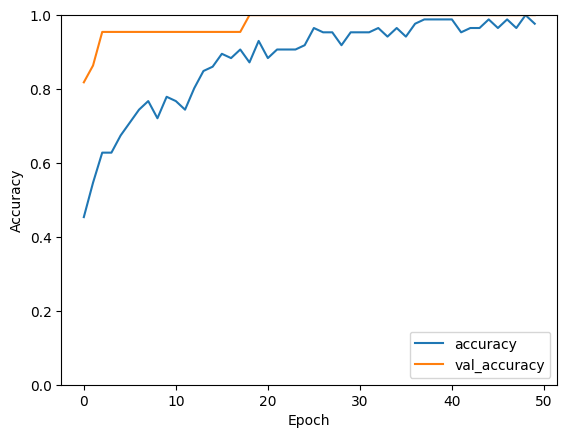

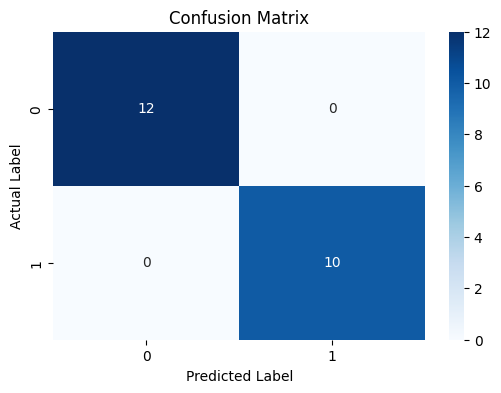

In [15]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19  # Changed to VGG19
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix  # Added confusion matrix
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Paths to ALL-IDB1 and ALL-IDB2
all_idb1_blast_dir = 'datasets\\ALL_IDB1\\all_blast'
all_idb1_normal_dir = 'datasets\\ALL_IDB1\\normal'
all_idb2_dir = 'datasets\\jpg img'

# Image parameters
img_height, img_width = 224, 224
batch_size = 32

# Sharpening filter
def adaptive_sharpen(image):
    blurred = cv2.GaussianBlur(image, (9, 9), 10.0)
    sharpened = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)
    return sharpened

# Load images
def load_images_from_dir(directory, label):
    data = []
    labels = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (img_width, img_height))
        image = adaptive_sharpen(image)
        image = image / 255.0
        labels.append(label)
        data.append(image)
    return np.array(data), np.array(labels)

all_idb1_blast_data, all_idb1_blast_labels = load_images_from_dir(all_idb1_blast_dir, 1)
all_idb1_normal_data, all_idb1_normal_labels = load_images_from_dir(all_idb1_normal_dir, 0)
# all_idb2_data, all_idb2_labels = load_images_from_dir(all_idb2_dir, 1)

# Combine data  
data = np.concatenate([all_idb1_blast_data, all_idb1_normal_data])
labels = np.concatenate([all_idb1_blast_labels, all_idb1_normal_labels])

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))


# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Define input shape
input_shape = (224, 224, 3)

# Input layer
inputs = Input(shape=input_shape)

# Load pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_tensor=inputs)
base_model.trainable = False  # Freeze the base model

# Add Flatten layer
x = Flatten()(base_model.output)

# Add fully connected layers
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)

# Output layer (Binary classification: 0 or 1)
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_vgg19.keras', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    epochs=50,
                    callbacks=[early_stopping, model_checkpoint],
                    class_weight=class_weights)

# Fine-tuning
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])
history_finetune = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
                             validation_data=(X_test, y_test),
                             epochs=20,
                             callbacks=[early_stopping, model_checkpoint],
                             class_weight=class_weights)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Classification Report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot Confusion Matrix using Heatmap
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

model.save('vgg19.keras')

In [16]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             

 Total params: 79,440,581 (303.04 MB)

 Trainable params: 26,480,193 (101.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 52,960,388 (202.03 MB)

In [18]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Load the model correctly
model = load_model('vgg19.keras') 

# Ensure input image is properly preprocessed
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Resize the image to the required input size of the VGG16 model
    image = cv2.resize(image, (224, 224))
    
    # Normalize the image (from [0, 255] to [0, 1])
    image = image / 255.0
    
    # Expand dimensions to match the model input shape (1, 224, 224, 3)
    image = np.expand_dims(image, axis=0)
    
    return image

# Function to predict the label of an input image
def predict_image(image_path):
    # Preprocess the image
    image = preprocess_image(image_path)
    
    # Predict using the loaded model
    prediction = model.predict(image)
    
    # Convert prediction to class label (0 or 1)
    predicted_label = int(prediction[0][0] > 0.5)
    
    # Label mapping (0: Normal, 1: Blast)
    labels = {0: 'Normal', 1: 'Blast'}
    
    # return labels[predicted_label]
    return labels[predicted_label]

# Test the prediction function
image_path = 'Im005_1.jpg'  # Replace with the path to your test image
predicted_label = predict_image(image_path)
print(f'Predicted label: {predicted_label}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
Predicted label: Blast


VGG16

Epoch 1/50


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - accuracy: 0.4889 - loss: 0.9053 - val_accuracy: 0.5455 - val_loss: 0.7326
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - accuracy: 0.5032 - loss: 0.8037 - val_accuracy: 0.5455 - val_loss: 0.6792
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 0.5493 - loss: 0.7525 - val_accuracy: 0.7273 - val_loss: 0.6558
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.5875 - loss: 0.6628 - val_accuracy: 0.7273 - val_loss: 0.6421
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 6s/step - accuracy: 0.5995 - loss: 0.6356 - val_accuracy: 0.5909 - val_loss: 0.6269
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - accuracy: 0.6152 - loss: 0.6262 - val_accuracy: 0.6364 - val_loss: 0.5984
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - accuracy: 0.6986 - loss: 0.5685 - val_accuracy: 0.7727 - val_loss: 0.5621
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 9s/step - accuracy: 0.7179 - loss: 0.5980 - val_accuracy: 0.8636 - val_loss: 0.5242
Epoch 9/50
3/3 ━━━━

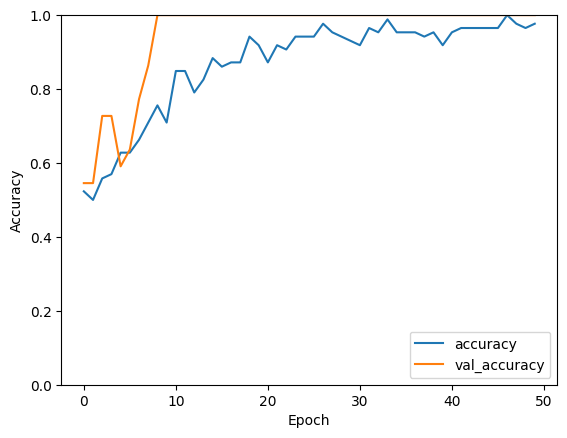

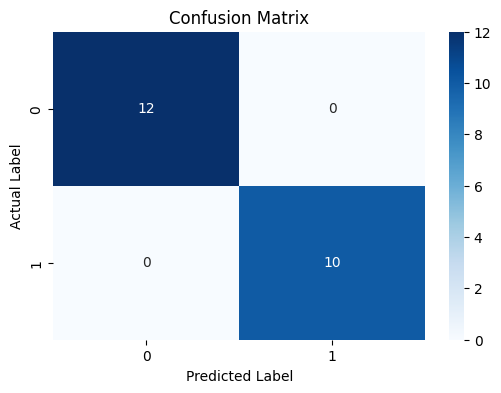

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16  # Changed to VGG19
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix  # Added confusion matrix
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Paths to ALL-IDB1 and ALL-IDB2
all_idb1_blast_dir = 'datasets\\ALL_IDB1\\all_blast'
all_idb1_normal_dir = 'datasets\\ALL_IDB1\\normal'

# Image parameters
img_height, img_width = 224, 224
batch_size = 32

# Sharpening filter
def adaptive_sharpen(image):
    blurred = cv2.GaussianBlur(image, (9, 9), 10.0)
    sharpened = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)
    return sharpened

# Load images
def load_images_from_dir(directory, label):
    data = []
    labels = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (img_width, img_height))
        image = adaptive_sharpen(image)
        image = image / 255.0
        labels.append(label)
        data.append(image)
    return np.array(data), np.array(labels)

all_idb1_blast_data, all_idb1_blast_labels = load_images_from_dir(all_idb1_blast_dir, 1)
all_idb1_normal_data, all_idb1_normal_labels = load_images_from_dir(all_idb1_normal_dir, 0)


# Combine data  
data = np.concatenate([all_idb1_blast_data, all_idb1_normal_data])
labels = np.concatenate([all_idb1_blast_labels, all_idb1_normal_labels])

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))


# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Define input shape
input_shape = (224, 224, 3)

# Input layer
inputs = Input(shape=input_shape)

# Load pre-trained VGG19 model
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)
base_model.trainable = False  # Freeze the base model

# Add Flatten layer
x = Flatten()(base_model.output)

# Add fully connected layers
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)

# Output layer (Binary classification: 0 or 1)
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_vgg19.keras', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    epochs=50,
                    callbacks=[early_stopping, model_checkpoint],
                    class_weight=class_weights)

# Fine-tuning
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])
history_finetune = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
                             validation_data=(X_test, y_test),
                             epochs=20,
                             callbacks=[early_stopping, model_checkpoint],
                             class_weight=class_weights)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Classification Report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot Confusion Matrix using Heatmap
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

model.save('vgg.keras')

In [2]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,511,493 (242.28 MB)

 Trainable params: 21,170,497 (80.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 42,340,996 (161.52 MB)

In [4]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Load the model correctly
model = load_model('vgg.keras') 

# Ensure input image is properly preprocessed
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Resize the image to the required input size of the VGG16 model
    image = cv2.resize(image, (224, 224))
    
    # Normalize the image (from [0, 255] to [0, 1])
    image = image / 255.0
    
    # Expand dimensions to match the model input shape (1, 224, 224, 3)
    image = np.expand_dims(image, axis=0)
    
    return image

# Function to predict the label of an input image
def predict_image(image_path):
    # Preprocess the image
    image = preprocess_image(image_path)
    
    # Predict using the loaded model
    prediction = model.predict(image)
    
    # Convert prediction to class label (0 or 1)
    predicted_label = int(prediction[0][0] > 0.5)
    
    # Label mapping (0: Normal, 1: Blast)
    labels = {0: 'Normal', 1: 'Blast'}
    
    # return labels[predicted_label]
    return labels[predicted_label]

# Test the prediction function
image_path = 'datasets\\ALL_IDB1\\normal\\Im034_0.jpg'  # Replace with the path to your test image
predicted_label = predict_image(image_path)
print(f'Predicted label: {predicted_label}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
Predicted label: Normal
